In [32]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
# from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import Counter
from skimage import color as scolor
from PIL import Image
from datetime import datetime
from dotenv import load_dotenv

In [33]:
load_dotenv()
folder_path = os.getenv('file_path_Munch')
df_lines_circles = os.getenv('dataset_lines_circles')
# folder_path = './data/paintings'
# folder_path

In [34]:
files = os.listdir(folder_path)
target_files = []
for f in files:
    if ('.jpg' in f) or ('.jpeg' in f):
        target_files.append(os.path.join(folder_path, f))

print('Количество картин в датасете:', len(target_files))

Количество картин в датасете: 220


### Смотрим, сколько картин художник написал за каждый год жизни

In [35]:
dates = []
for i in target_files:
    date = i.split('/')[-1].split('_')[0]
    dates.append(date)

In [36]:
from collections import Counter

year_counts = dict(Counter(dates))
del year_counts['yyyy']

In [37]:
df = pd.DataFrame(dates, columns=['year'])
df.shape

(220, 1)

In [38]:
df['unknown'] = df.year.apply(lambda x: True if x == 'yyyy' else False)
df.unknown.value_counts()

unknown
False    217
True       3
Name: count, dtype: int64

In [39]:
result = df.groupby('year', as_index=False).agg({'unknown': 'count'}).rename(columns={'unknown': 'count'})

In [40]:
mask = df[df.unknown == False].year.to_list()
mask.sort()
# mask

In [41]:
mask.extend(['yyyy' for _ in range(4)])
len(mask)

221

In [42]:
sns.set_theme(style="white")

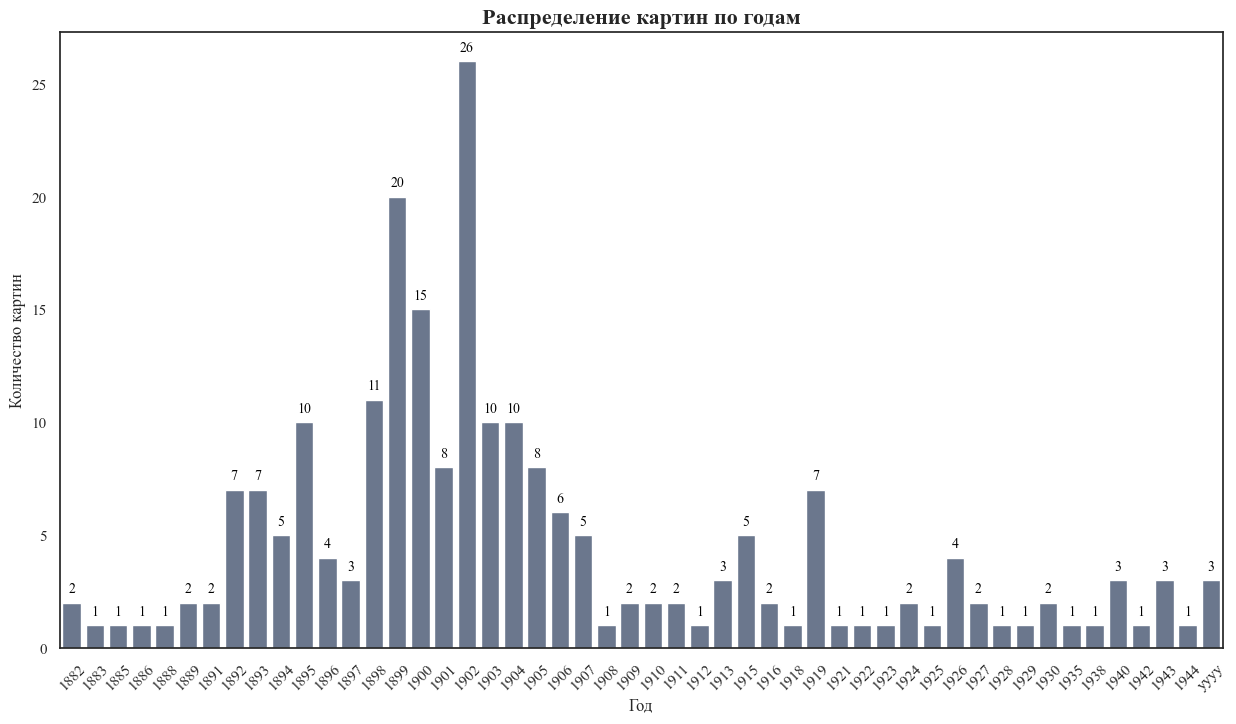

In [43]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.figure(figsize=(15, 8))

color_hex = '#{:02x}{:02x}{:02x}'.format(102, 118, 146)
bar_plot = sns.barplot(data=result, x='year', y='count', color=color_hex, order=mask)

plt.title('Распределение картин по годам', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Год', fontdict={'fontsize': 12})
plt.ylabel('Количество картин', fontdict={'fontsize': 12})
plt.xticks(rotation=45)


for p in bar_plot.patches:
    bar_plot.annotate(format(int(p.get_height())), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black', 
                        xytext=(0, 5), textcoords='offset points')

plt.show()

In [44]:
df_counts = pd.DataFrame(year_counts.items(), columns=['year', 'count'])
df_counts.head()

,year,count
0,1938,1
1,1895,10
2,1902,26
3,1893,7
4,1888,1


### Смотрим 7 самых часто встречающихся диапазонов цветов на всех картинках

In [45]:
def rgb_to_lab(rgb_array):

    rgb_array = rgb_array / 255.0  # normalizing RGB
    lab_array = scolor.rgb2lab(rgb_array)
    
    return lab_array

In [46]:
def get_pixels_from_folder(folder_path, rgb_lab):

    all_pixels = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((128, 128))
                pixels = np.array(img)
                all_pixels.append(pixels.reshape(-1, 3))

            except Exception as e:
                print(f"Can't open {filename}: {e}")

    # combine all pixels into one vector
    if all_pixels:
        rgb_vector = np.vstack(all_pixels) 
        if rgb_lab == 'RGB':
            return rgb_vector
        elif rgb_lab == 'LAB':
            lab_vector = rgb_to_lab(rgb_vector)
            return lab_vector
    else:
        return np.array([])

In [47]:
# finding the n most common color ranges in the !RGB vector! and sort them by frequency
def find_most_common_colors(vector, rgb_lab, classifier_type, n_colors=7):
    
    if vector.size == 0:
        print("Vector is empty")
        return []

    if classifier_type == 'KMeans':
        results_cluster = KMeans(n_clusters=n_colors)
        results_cluster.fit(vector)
        colors = results_cluster.cluster_centers_
    elif classifier_type == 'GM':
        results_cluster = GaussianMixture(n_components=n_colors, random_state=42)
        results_cluster.fit(vector)
        colors = results_cluster.means_
        labels = results_cluster.predict(vector) # 'GaussianMixture' object has no attribute 'labels_'
    elif classifier_type == 'GMM':
        gmm = BayesianGaussianMixture(n_components=n_colors, random_state=42)
        gmm.fit(vector)
        colors = gmm.means_
        labels = gmm.predict(vector)
        
        
    # colors = results_cluster.cluster_centers_
    
    if rgb_lab == 'LAB':
        rgb_colors = scolor.lab2rgb(colors.reshape(1, -1, 3)).reshape(-1, 3) * 255 # LAB to RGB
    elif rgb_lab == 'RGB':
        rgb_colors = colors        
    rgb_colors = np.clip(rgb_colors, 0, 255).astype(int)

    # counting pixels of each cluster by color
    if classifier_type == 'KMeans':
        labels = results_cluster.labels_
        label_counts = Counter(labels)
    elif classifier_type == 'GM':
        label_counts = Counter(labels)
    elif classifier_type == 'GMM':
        # labels = gmm.predict(lab_vector)
        label_counts = Counter(labels)

    sorted_colors = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_rgb_colors = rgb_colors[[color[0] for color in sorted_colors]]

    return sorted_rgb_colors

In [48]:
def plot_colors(colors):
    plt.figure(figsize=(15, 6))
    plt.imshow([colors], aspect='auto')
    
    for i, color in enumerate(colors):
        plt.text(i, 0, str(i+1), ha='center', va='center', fontsize=20, color='white')
    
    plt.axis('off')
    plt.show()

##### Без перевода из RGB в Lab с помощью KMeans:

In [49]:
pixels_vector = get_pixels_from_folder(folder_path, rgb_lab='RGB')

In [50]:
most_common_colors_nolab = find_most_common_colors(pixels_vector, rgb_lab='RGB', classifier_type='KMeans', n_colors=7)

Семь самых распространенных цветов (RGB):
Цвет 1: [66 67 64]
Цвет 2: [32 32 32]
Цвет 3: [132  87  57]
Цвет 4: [173 164 153]
Цвет 5: [104 120 130]
Цвет 6: [188 141  80]
Цвет 7: [218 209 192]


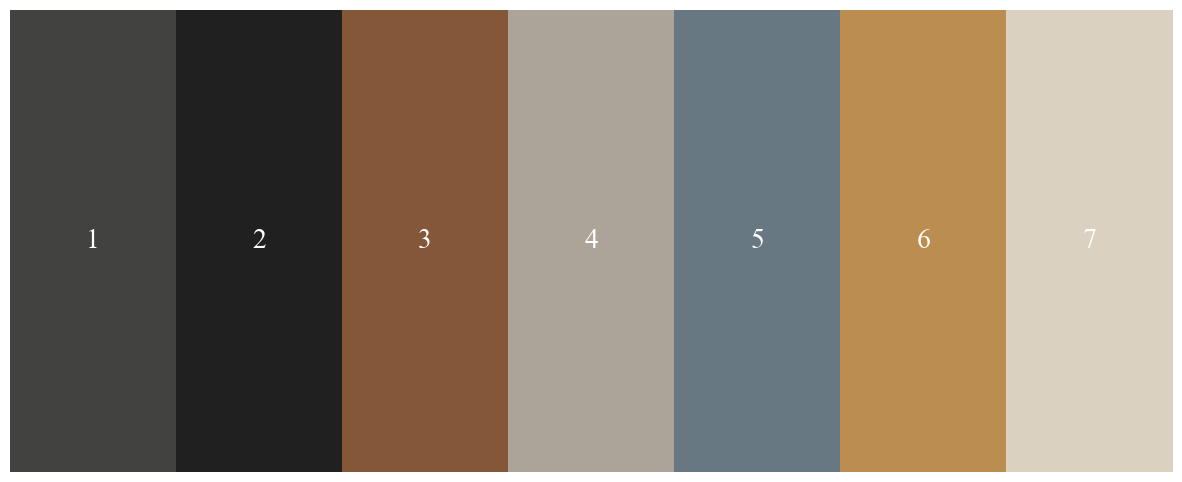

In [51]:
print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_nolab:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_nolab)

##### С переводом из RGB в LAB с помощью KMeans:

In [52]:
pixels_vector = get_pixels_from_folder(folder_path, rgb_lab='LAB')

In [53]:
most_common_colors = find_most_common_colors(pixels_vector, rgb_lab='LAB', classifier_type='KMeans', n_colors=7)

Семь самых распространенных цветов (RGB -> LAB -> RGB):
Цвет 1: [36 35 39]
Цвет 2: [76 70 60]
Цвет 3: [197 189 178]
Цвет 4: [135 123  95]
Цвет 5: [100 117 145]
Цвет 6: [153  80  50]
Цвет 7: [198 159  84]


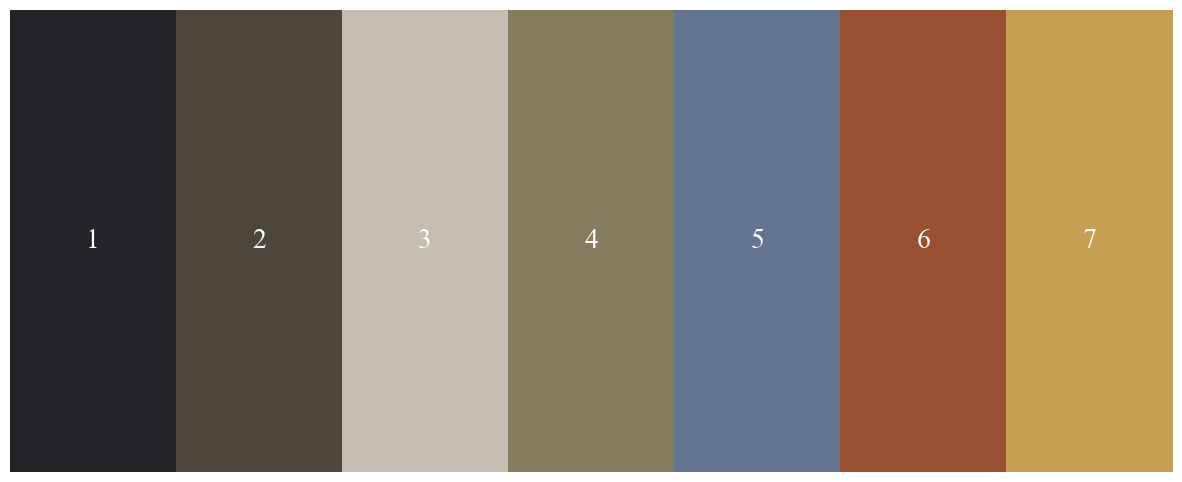

In [54]:
print("Семь самых распространенных цветов (RGB -> LAB -> RGB):")
c = 1
for i in most_common_colors:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors)

##### С переводом из RGB в LAB с помощью GaussianMixture:

In [55]:
pixels_vector = get_pixels_from_folder(folder_path, rgb_lab='LAB')

In [56]:
most_common_colors_gauss = find_most_common_colors(pixels_vector, rgb_lab='LAB', classifier_type='GM', n_colors=7)

Семь самых распространенных цветов (RGB):
Цвет 1: [35 36 39]
Цвет 2: [73 64 55]
Цвет 3: [139 125 100]
Цвет 4: [192 184 173]
Цвет 5: [ 82  98 120]
Цвет 6: [137  77  48]
Цвет 7: [199 160  96]


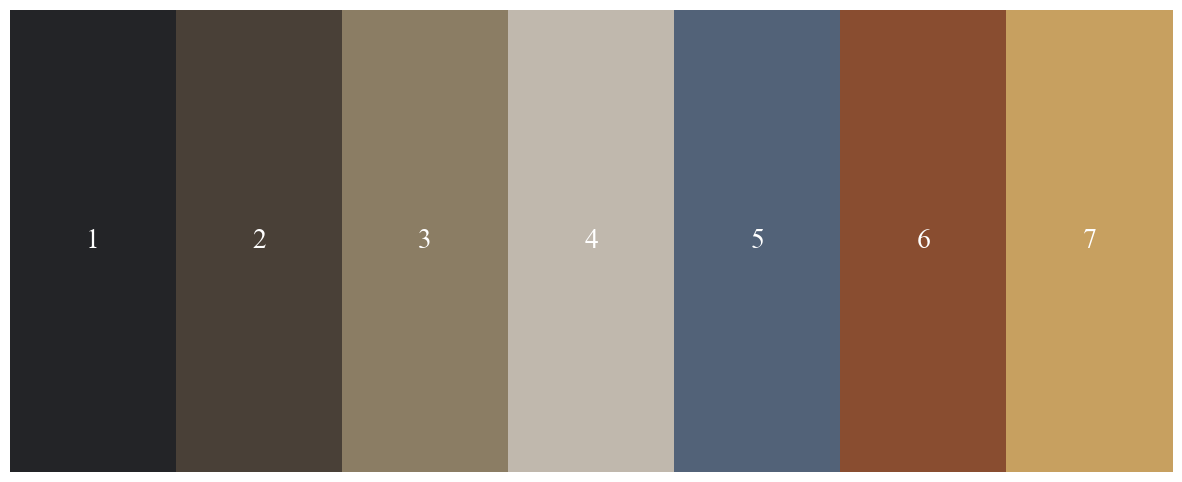

In [57]:
print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_gauss:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_gauss)

##### С переводом из RGB в LAB с помощью BayesianGaussianMixture:

In [58]:
pixels_vector = get_pixels_from_folder(folder_path, rgb_lab='LAB')

In [59]:
most_common_colors_gaussbayes = find_most_common_colors(pixels_vector, rgb_lab='LAB', classifier_type='GMM', n_colors=7)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Семь самых распространенных цветов (RGB):
Цвет 1: [126 124 113]
Цвет 2: [51 50 49]
Цвет 3: [125  78  53]
Цвет 4: [199 164 114]
Цвет 5: [201 195 184]
Цвет 6: [21 22 24]
Цвет 7: [55 73 93]


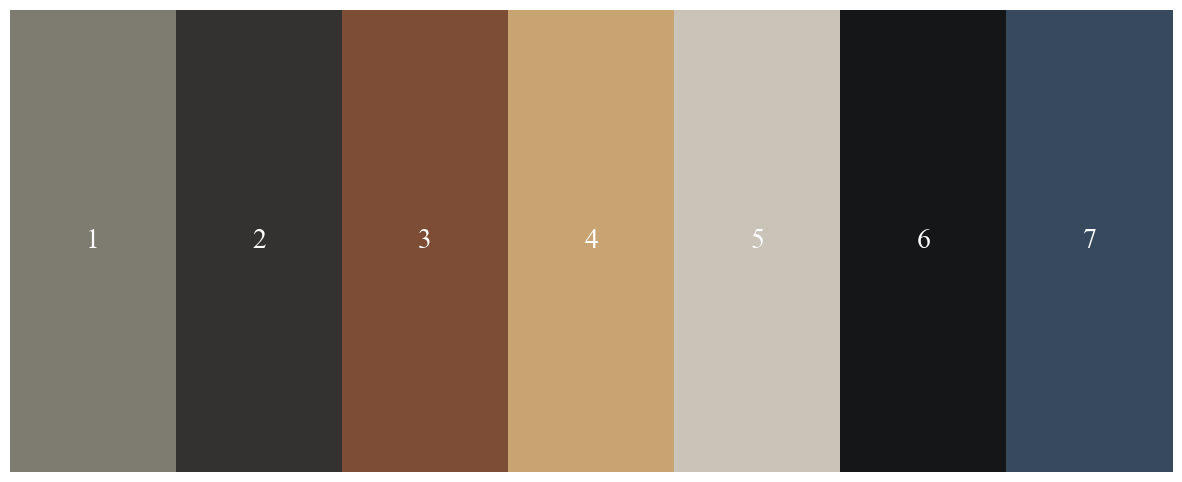

In [60]:
print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_gaussbayes:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_gaussbayes)

### Смотрим, как часто эти цвета встречаются по годам

In [61]:
def sum_pixels_by_year(results, years):

    summed_results = {color: [] for color in results.keys()}
    unique_years = sorted(list(set(years)))

    for year in unique_years:
        indices = [i for i, y in enumerate(years) if y == year]
        for color in results.keys():
            summed_value = np.sum([results[color][i] for i in indices])
            summed_results[color].append(summed_value)

    return summed_results, unique_years

In [62]:
def min_max_normalization(data):
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) for x in data]

In [63]:
def count_pixels_in_range(image_path, color, tolerance=20):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img)

    # defining the boundaries for each channel
    lower_bound = np.array(color) - tolerance
    upper_bound = np.array(color) + tolerance

    # mask for pixels falling within the range
    mask = np.all((img_array >= lower_bound) & (img_array <= upper_bound), axis=-1)

    return np.sum(mask)  # number of pixels corresponding to color

In [64]:
def extract_date_from_filename(filename):
    try:
        year, month, day = map(int, filename.split('_')[:3])
        return datetime(year, month, day)
    except (IndexError, ValueError):
        return None
    
def extract_year_from_filename(filename):
    try:
        year = int(filename.split('_')[0])
        return year
    except (IndexError, ValueError):
        return None 

In [65]:
# analyzing the images in the specified folder and returns the number of pixels for each color
def analyze_most_popular_ever_colors(folder_path, colors):

    results = {tuple(color): [] for color in colors}
    years = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            
            year = extract_year_from_filename(filename)
            if year is None:
                continue
            years.append(year)

            pixel_counts = []
            for color in colors:
                count = count_pixels_in_range(image_path, color, tolerance=20)
                pixel_counts.append(count)

            for i, color in enumerate(colors):
                results[tuple(color)].append(pixel_counts[i])

    # converting the results into a numpy array for sorting
    years = np.array(years)
    for color in results:
        results[color] = np.array(results[color])

    # sorting by year
    sorted_indices = np.argsort(years)
    years = years[sorted_indices]
    for color in results:
        results[color] = results[color][sorted_indices]

    return results, years

In [66]:
def plot_bar_distribution(results, years, model_name):
    
    results, years = sum_pixels_by_year(results, years)

    colors = list(results.keys())
    counts = np.array(list(results.values()))

    year_pixel_counts = {year: np.zeros(len(colors)) for year in years}

    # sum pixels by year
    for i, year in enumerate(years):
        for j, color in enumerate(colors):
            year_pixel_counts[year][j] += counts[j][i]

    # converting the data into an array to build a graph
    summed_counts = np.array(list(year_pixel_counts.values()))
    summed_counts = summed_counts / summed_counts.sum(axis=1, keepdims=True)

    # convert colors to format for matplotlib (from 0 to 1)
    color_palette = [(r/255, g/255, b/255) for r, g, b in colors]

    sns.set_theme(style="white")
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    
    plt.figure(figsize=(15, 10))

    bottom = np.zeros(len(years))
    for i, color in enumerate(colors):
        plt.bar(range(len(years)), summed_counts[:, i], bottom=bottom, color=color_palette[i], label=f'Color {color}')
        bottom += summed_counts[:, i]  # update the lower limit for accumulation

    plt.title(f'Распределение 7 самых часто встречающихся цветов по годам ({model_name})', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('Год', fontdict={'fontsize': 12})
    plt.ylabel('Количество пикселей (нормализованное)', fontdict={'fontsize': 12})
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    plt.show()

#### KMeans:

In [67]:
results, years = analyze_most_popular_ever_colors(folder_path, np.array(most_common_colors))

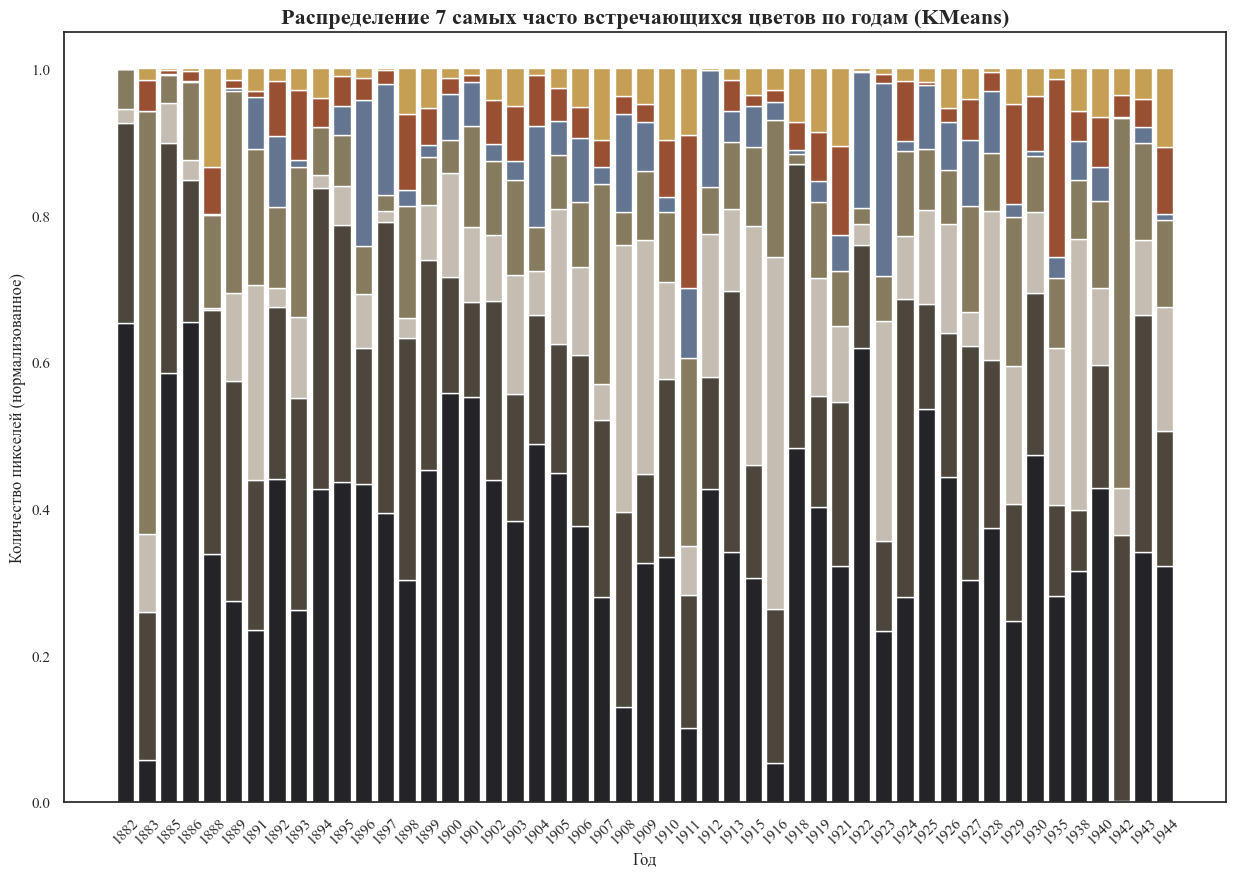

In [68]:
plot_bar_distribution(results, years, model_name='KMeans')

In [69]:
from pprint import pprint

pprint(results)

{(36, 35, 39): array([4176, 5327,  252, 6388, 5862, 2627, 1317, 1811, 1190,  520, 4914,
        983, 1291, 2738, 3411, 3474,  961, 5304, 1058,   23, 1357,  175,
       1063, 1191, 6181, 6676,  200, 1295, 4430, 4405, 2730, 3231,   52,
       1114, 6089, 5393,    9, 5296, 2052, 1742, 2104, 1645, 2789, 2263,
        769, 3340,  340, 3438,    5, 2154, 2344, 4371, 1434, 1266,  300,
        218, 5565, 5422, 2357, 6088, 1142, 2779, 2884, 2751,  590, 8034,
       4015, 2967, 3934,  964, 1792,  309,   12,  633,  904, 4790,  877,
       5103, 2574,  991, 5499, 1300, 1126, 3075,  557, 4041, 6543, 8137,
       4510, 6195, 4586, 1088, 5990, 1092, 4730,  695, 3304, 4185, 3707,
       7420, 2045, 3307, 4149, 6222, 6997,  102, 3534,  326, 2605, 5572,
        283, 2512, 1723, 1373, 2138,  330, 8528,  820, 2769, 1991, 2531,
       1695, 1242, 2190, 1226, 1639, 1322, 3739, 1315, 1187,  455,  215,
       3188, 4959, 4921, 3022, 5127, 4329, 4286, 2600,  940,  441,  657,
       3934, 3322, 1678, 4534, 1910,

In [70]:
df_KMeans = pd.DataFrame.from_dict(results, orient='index', columns=years)
df_KMeans = df_KMeans.T
df_KMeans = df_KMeans.reset_index().rename(columns={'index': 'year'})

In [71]:
df_KMeans = df_KMeans.groupby('year', as_index=False).sum()

In [72]:
df_KMeans.head()

,year,"(36, 35, 39)","(76, 70, 60)","(197, 189, 178)","(135, 123, 95)","(100, 117, 145)","(153, 80, 50)","(198, 159, 84)"
0,1882,9503,3978,269,802,0,5,7
1,1883,252,884,463,2527,0,189,68
2,1885,6388,3420,602,407,22,49,29
3,1886,5862,1731,254,948,10,126,30
4,1888,2627,2598,22,990,1,502,1049


#### GaussianMixture:

In [73]:
results_GM, years = analyze_most_popular_ever_colors(folder_path, np.array(most_common_colors_gauss))

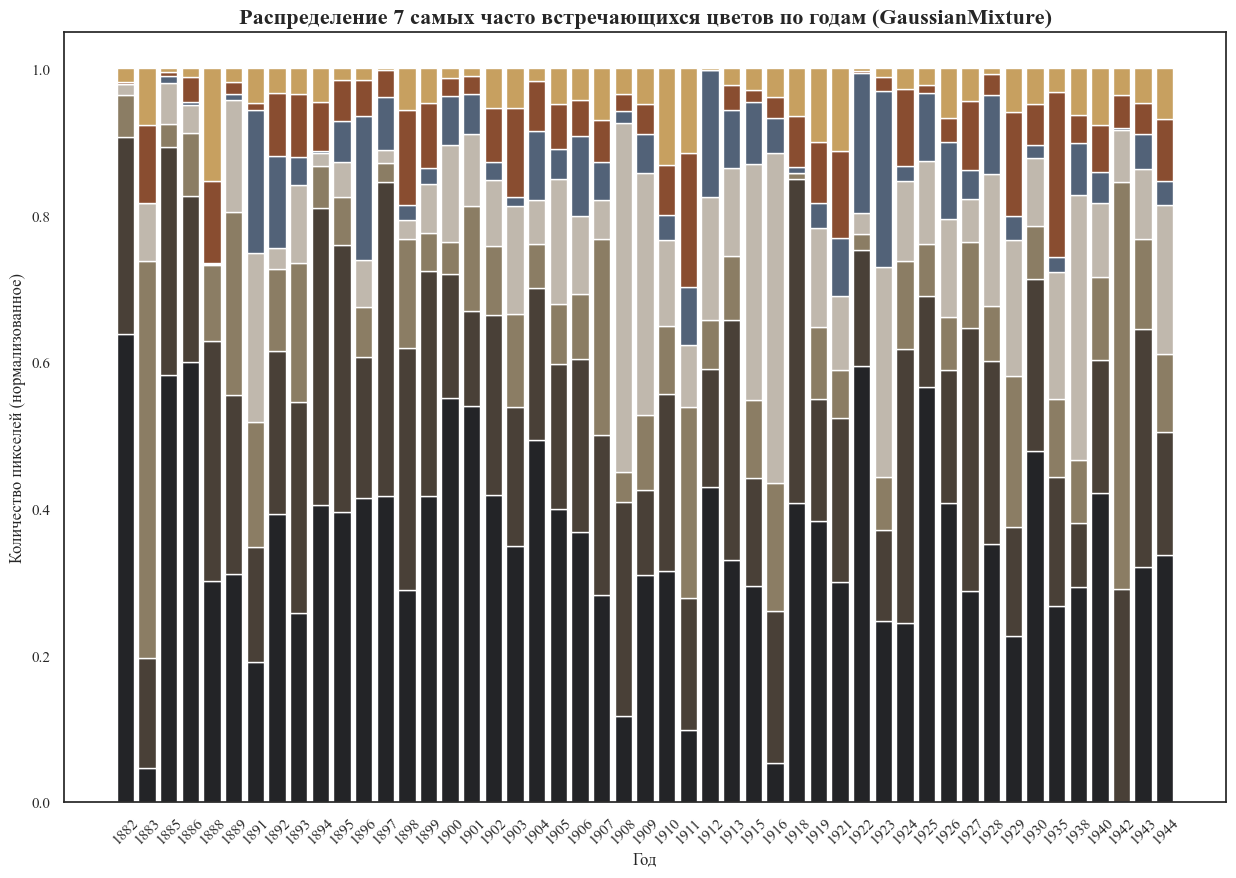

In [74]:
plot_bar_distribution(results_GM, years, model_name='GaussianMixture')

In [75]:
df_GM = pd.DataFrame.from_dict(results_GM, orient='index', columns=years)
df_GM = df_GM.T
df_GM = df_GM.reset_index().rename(columns={'index': 'year'})
df_GM = df_GM.groupby('year', as_index=False).sum()
df_GM.head()

,year,"(35, 36, 39)","(73, 64, 55)","(139, 125, 100)","(192, 184, 173)","(82, 98, 120)","(137, 77, 48)","(199, 160, 96)"
0,1882,9540,4024,844,230,13,36,271
1,1883,242,786,2828,410,1,555,403
2,1885,6573,3510,365,630,106,69,48
3,1886,5856,2217,830,376,37,330,120
4,1888,2551,2783,870,21,10,945,1302


In [76]:
len(df_GM)

49

#### BayesianGaussianMixture:

In [77]:
results_BGM, years = analyze_most_popular_ever_colors(folder_path, np.array(most_common_colors_gaussbayes))

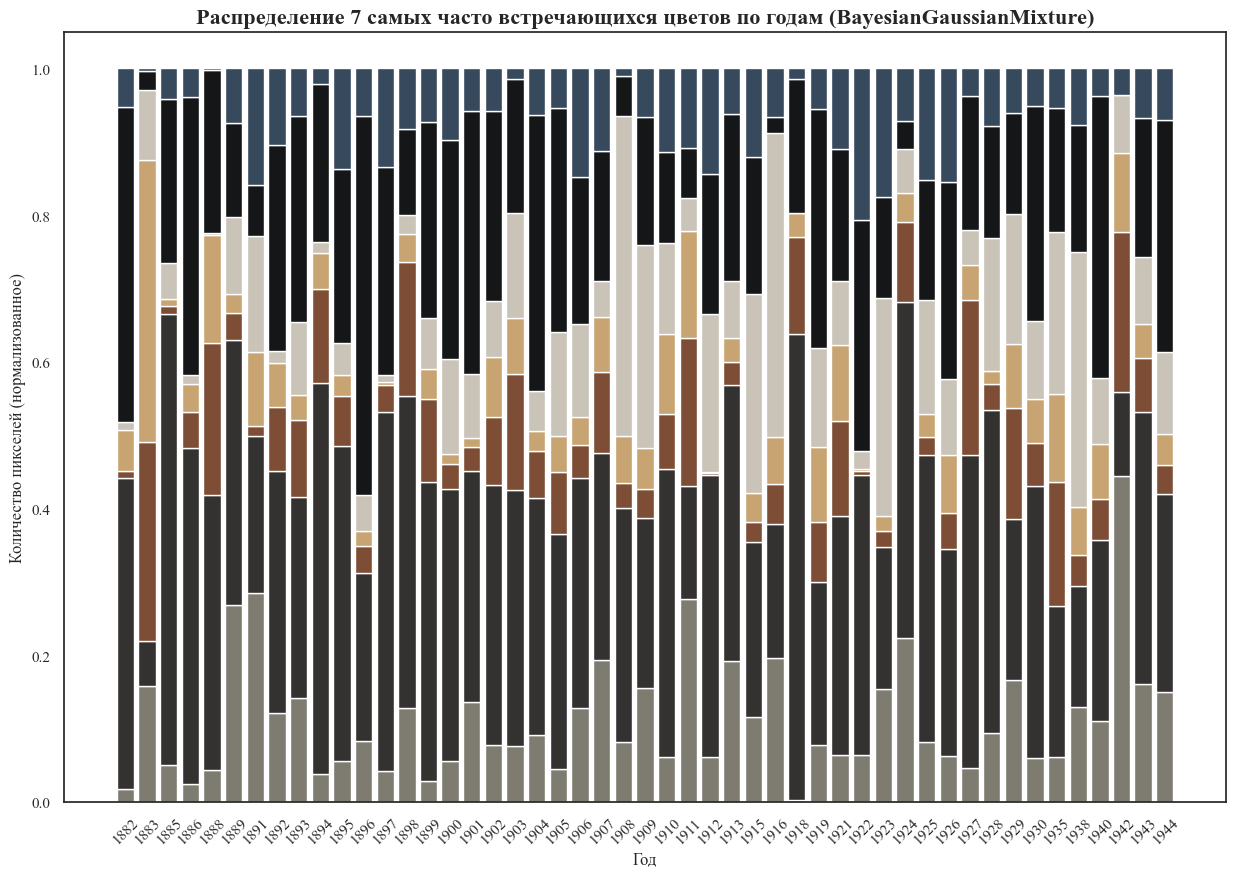

In [78]:
plot_bar_distribution(results_BGM, years, model_name='BayesianGaussianMixture')

In [79]:
df_BGM = pd.DataFrame.from_dict(results_BGM, orient='index', columns=years)
df_BGM = df_BGM.T
df_BGM = df_BGM.reset_index().rename(columns={'index': 'year'})
df_BGM = df_BGM.groupby('year', as_index=False).sum()
df_BGM.head()

,year,"(126, 124, 113)","(51, 50, 49)","(125, 78, 53)","(199, 164, 114)","(201, 195, 184)","(21, 22, 24)","(55, 73, 93)"
0,1882,471,11074,229,1465,303,11192,1388
1,1883,814,321,1403,1988,492,135,17
2,1885,577,6982,126,103,561,2532,481
3,1886,307,5684,612,469,154,4721,477
4,1888,333,2897,1588,1141,20,1710,20


In [80]:
len(df_BGM)

49

#### KMeans (без перевода в LAB):

In [81]:
results_gb, years = analyze_most_popular_ever_colors(folder_path, np.array(most_common_colors_nolab))

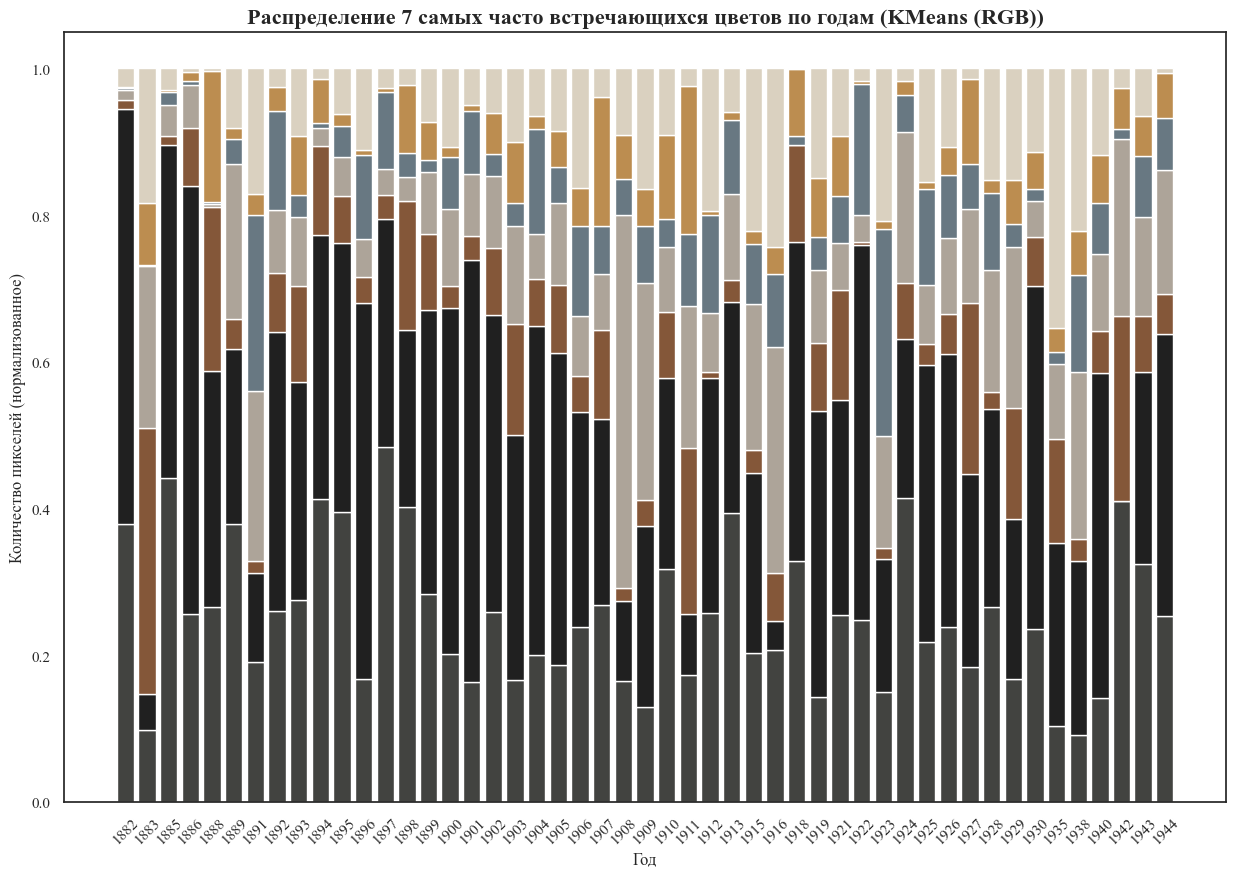

In [82]:
plot_bar_distribution(results_gb, years, model_name='KMeans (RGB)')

### Смотрим отдельно основные цвета

In [83]:
def is_color_in_range(lab_pixel, lower_bound, upper_bound):
    return np.all((lab_pixel >= lower_bound) & (lab_pixel <= upper_bound))

In [84]:
def count_pixels_in_color_range(image_path, lower_bound, upper_bound):
    img = cv2.imread(image_path)
    
    img = cv2.resize(img, (128, 128)) 
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_array = img_lab.reshape(-1, 3)
    
    mask = np.apply_along_axis(is_color_in_range, 1, lab_array, lower_bound, upper_bound)
    total_pixels = lab_array.shape[0]
    
    color_pixel_count = np.sum(mask)
    return color_pixel_count, total_pixels

In [85]:
def analyze_images_in_range(folder_path, lower_bound, upper_bound):
    results = {}
    total_pixels_per_year = {}
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            
            year = extract_year_from_filename(filename)
            if year is None:
                continue
            
            color_count, total_pixels = count_pixels_in_color_range(image_path, lower_bound, upper_bound)
            
            if year in results:
                results[year] += color_count
                total_pixels_per_year[year] += total_pixels
            else:
                results[year] = color_count
                total_pixels_per_year[year] = total_pixels
    
    years = np.array(list(results.keys()))
    normalized_counts = np.array([results[year] for year in years]) # / total_pixels_per_year[year] for year in years])
    
    sorted_indices = np.argsort(years)
    years = years[sorted_indices]
    normalized_counts = normalized_counts[sorted_indices]
    
    return normalized_counts, years

In [86]:
def plot_color_distribution(results, years, color_name, color_hex):
    sns.set_theme(style="white")
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    
    plt.figure(figsize=(15, 10))
    plt.bar(range(len(years)), results, color=color_hex, label=f'{color_name} диапазон')
    plt.title(f'Распределение цвета ({color_name}) по годам', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('Год', fontdict={'fontsize': 12})
    plt.ylabel('Доля пикселей в изображениях', fontdict={'fontsize': 12})
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    # plt.legend(loc='upper left')
    plt.xlim(-0.5, len(years) - 0.5)
    plt.show()

In [87]:
def get_lab_color_range(lab_center, tolerance):
    lower_bound = np.clip(lab_center - tolerance, [0, -128, -128], [100, 127, 127])
    upper_bound = np.clip(lab_center + tolerance, [0, -128, -128], [100, 127, 127])
    return lower_bound, upper_bound

In [88]:
def analyze_images_by_color_mean(folder_path, color):
    results = {}
    total_pixels_per_year = {}
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            
            year = extract_year_from_filename(filename)
            im = cv2.imread(image_path, cv2.IMREAD_COLOR)
            im = cv2.resize(im, (128, 128))
            if color == 'red':
                im = im[:, :, 0]
            elif color == 'green':
                im = im[:, :,1]
            elif color == 'blue':
                im = im[:, :, 2]
            elif color == 'yellow':
                im = im[:, :, 0].astype(float) / 2 + im[:, :, 1].astype(float) / 2
            color_count = im.mean() / 256.

            if year is None:
                continue

            if year in results:
                results[year].append(color_count)
            else:
                results[year] = [color_count]

    for year in results:
        results[year] = np.mean(results[year])

    years = np.array(list(results.keys()))
    normalized_counts = np.array(list(results.values()))
    sorted_indices = np.argsort(years)
    years = years[sorted_indices]
    normalized_counts = normalized_counts[sorted_indices]
    

    return normalized_counts, years

#### Красный:

In [89]:
results, years = analyze_images_by_color_mean(folder_path, color='red')
results

array([0.22426093, 0.41224813, 0.28291154, 0.23448467, 0.25042987,
       0.39645278, 0.48916113, 0.32111359, 0.32416807, 0.25023193,
       0.31264625, 0.40089965, 0.32221429, 0.29037083, 0.28036442,
       0.34538579, 0.36546594, 0.3302745 , 0.35412931, 0.33089206,
       0.3263739 , 0.40137545, 0.32637992, 0.46993399, 0.44617367,
       0.36135566, 0.38074458, 0.55962896, 0.37580347, 0.43600173,
       0.44679761, 0.1999855 , 0.33822036, 0.3502717 , 0.47711492,
       0.57411098, 0.35468292, 0.46230936, 0.41017741, 0.39516079,
       0.42183948, 0.40275788, 0.30831039, 0.50392246, 0.45789456,
       0.36549958, 0.38749862, 0.37170235, 0.26354146])

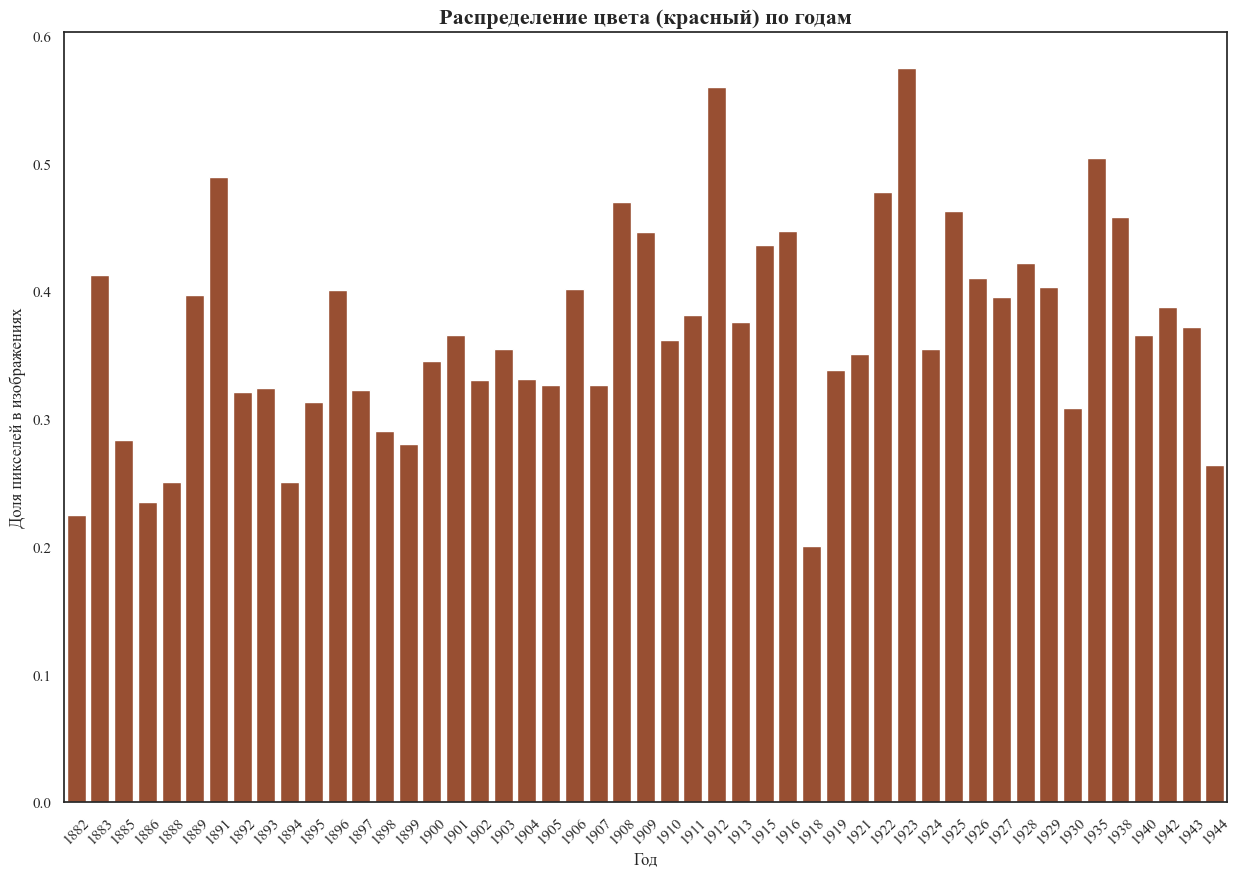

In [90]:
color_hex = '#{:02x}{:02x}{:02x}'.format(152, 79, 50)
plot_color_distribution(results, years, color_name="красный", color_hex=color_hex)

#### Зеленый:

In [91]:
results, years = analyze_images_by_color_mean(folder_path, color='green')

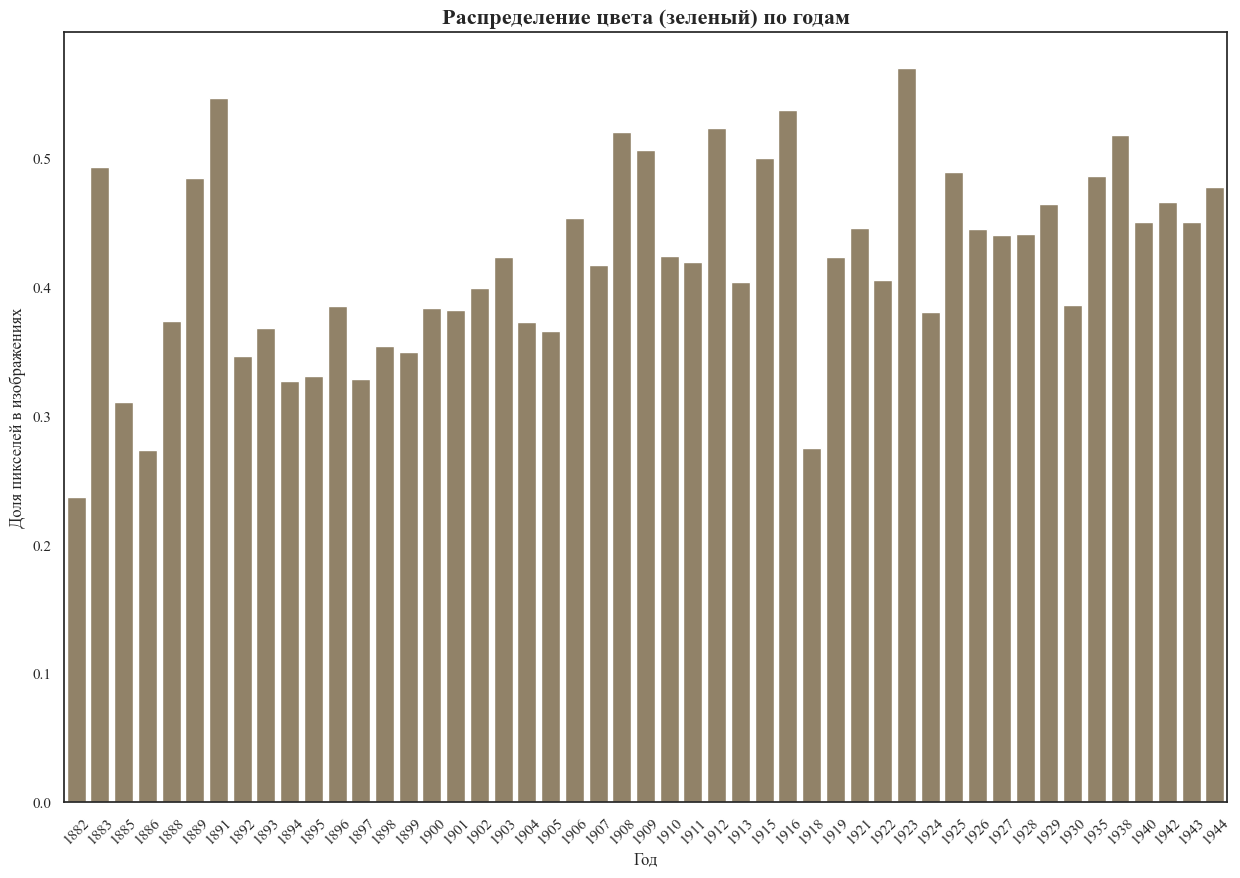

In [92]:
color_hex = '#{:02x}{:02x}{:02x}'.format(145, 130, 104)
plot_color_distribution(results, years, color_name="зеленый", color_hex=color_hex)

#### Синий:

In [93]:
results, years = analyze_images_by_color_mean(folder_path, color='blue')

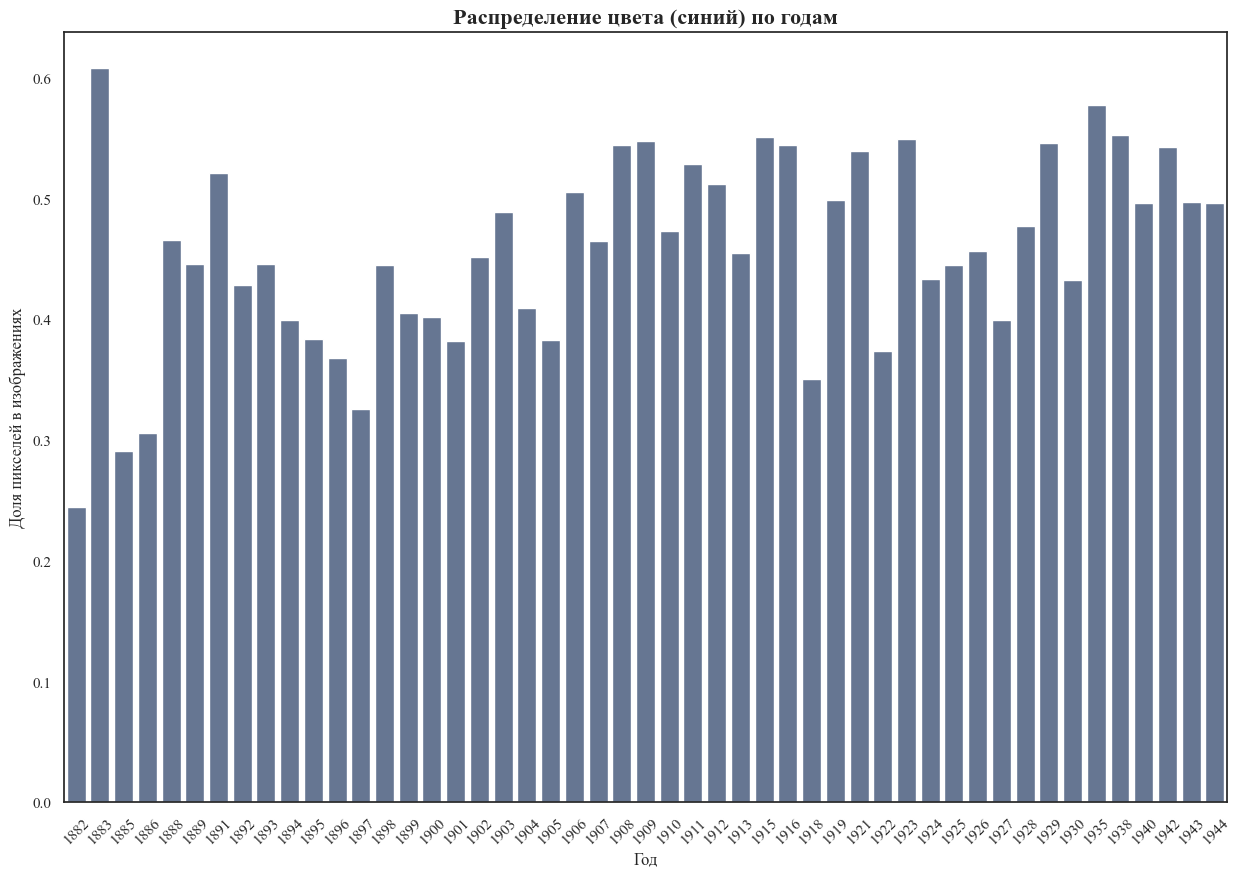

In [94]:
color_hex = '#{:02x}{:02x}{:02x}'.format(102, 118, 146)
plot_color_distribution(results, years, color_name="синий", color_hex=color_hex)

#### Желтый:

In [95]:
results, years = analyze_images_by_color_mean(folder_path, color='yellow')

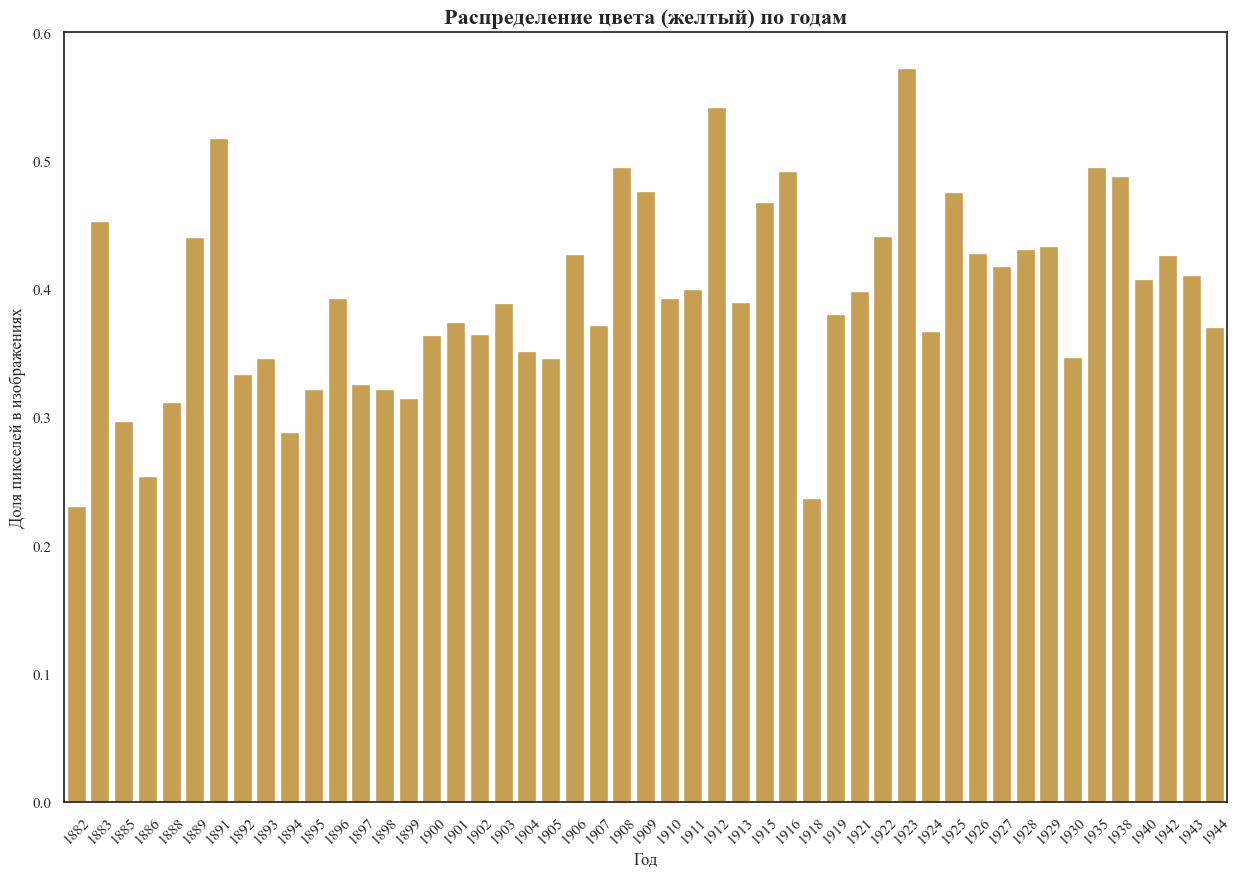

In [96]:
color_hex = '#{:02x}{:02x}{:02x}'.format(198, 159, 82)
plot_color_distribution(results, years, color_name="желтый", color_hex=color_hex)

### Смотрим 7 самых часто используемых цветов за каждый год

In [97]:
def rgb_to_lab(rgb_pixels):
    rgb_pixels = rgb_pixels / 255.0
    lab_pixels = scolor.rgb2lab(rgb_pixels.reshape(-1, 1, 3)).reshape(-1, 3)
    return lab_pixels

def lab_to_rgb(lab_color):
    lab_color = np.array(lab_color).reshape(1, 1, 3)
    rgb_color = scolor.lab2rgb(lab_color).reshape(3) * 255
    rgb_color = np.clip(rgb_color, 0, 255).astype(int)
    return tuple(rgb_color)

In [98]:
def get_most_common_colors(image_path, classifier, num_colors=7, resize_dim=(128, 128), rounding=10):
# def get_most_common_colors(image_path, classifier, num_colors=7, resize_dim=(50, 50), rounding=10):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(resize_dim)
    pixels = np.array(image).reshape(-1, 3)
    pixels = rgb_to_lab(pixels)

    if classifier == 'Counter':
        pixels = (pixels // rounding) * rounding
        color_counter = Counter(map(tuple, pixels))  # Преобразуем в кортежи
        most_common = color_counter.most_common(num_colors)
    
    elif classifier == 'KMeans':
        kmeans = KMeans(n_clusters=num_colors, random_state=42)
        kmeans.fit(pixels)
        labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_
        
        color_counter = Counter(labels)
        most_common1 = color_counter.most_common(num_colors)
        
        most_common = []
        for cluster_idx, count in most_common1:
            lab_color = cluster_centers[cluster_idx]
            rgb_color = lab_to_rgb(lab_color)
            # most_common.append((rgb_color, count))
            # most_common.append((tuple(rgb_color.astype(int)), count))
            most_common.append((rgb_color, count))
            

    elif classifier == 'GM':
        gmm = GaussianMixture(n_components=num_colors, random_state=42)
        gmm.fit(pixels)
        labels = gmm.predict(pixels)
        cluster_centers = gmm.means_

        # Подсчет количества пикселей в каждом кластере
        color_counter = Counter(labels)
        most_common_labels = color_counter.most_common(num_colors)

        most_common = []
        for cluster_idx, count in most_common_labels:
            lab_color = cluster_centers[cluster_idx]
            rgb_color = scolor.lab2rgb(lab_color.reshape(1, 1, 3)).reshape(3) * 255  # LAB → RGB
            most_common.append((tuple(rgb_color.astype(int)), count))  # Преобразуем в кортеж
            
    elif classifier == 'GMM':
        gmm = BayesianGaussianMixture(n_components=num_colors, random_state=42)
        gmm.fit(pixels)
        labels = gmm.predict(pixels)
        cluster_centers = gmm.means_
        
        color_counter = Counter(labels)
        most_common1 = color_counter.most_common(num_colors)
        
        most_common = []
        for cluster_idx, count in most_common1:
            lab_color = cluster_centers[cluster_idx]
            rgb_color = lab_to_rgb(lab_color)
            most_common.append((rgb_color, count))

    return most_common  # Список (цвет, количество пикселей)

In [99]:
def get_colors_by_year(images_folder, classifier):
    
    colors_by_year = {}
    
    for file in os.listdir(images_folder):
        if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
            try:
                year = file.split('_')[0]
                year = int(year)
            except ValueError:
                continue
            
            image_path = os.path.join(images_folder, file)
            common_colors = get_most_common_colors(image_path, classifier)
            
            if year not in colors_by_year:
                colors_by_year[year] = []
            
            # add color codes and pixel counts
            for color, count in common_colors:
                colors_by_year[year].append((color, count))
    
    # top-7 by each year
    top_colors_by_year = {}
    for year, colors in colors_by_year.items():
        if classifier == 'KMeans':
            # color_counter = Counter({tuple(color): count for color, count in colors.items()})
            color_counter = Counter(dict(colors)) 
        else:
            color_counter = Counter(dict(colors)) # count the number of pixels for each color
        top_colors = color_counter.most_common(7)
        top_colors_by_year[year] = {color: count for color, count in top_colors}
    
    return top_colors_by_year

In [100]:
def sort_colors_by_luminance(colors):
    # Calculate luminance (L channel) for each color in LAB space and sort by it
    lab_colors = np.array(colors)
    luminance = lab_colors[:, 0]  # L channel in LAB space
    sorted_indices = np.argsort(luminance)  # Sort based on luminance (L channel)
    return np.array(colors)[sorted_indices]

def calculate_brightness(lab_color):
    return lab_color[0]

In [101]:
def plot_color_distribution(colors_by_year, how, classifier):
    years = [year for year in sorted(colors_by_year.keys()) if colors_by_year[year]] # filter the years for which there is data
    
    # all colors
    all_colors = set()
    for color_dict in colors_by_year.values():
        all_colors.update(color_dict.keys())
    all_colors = list(all_colors)
    
    data = {color: [] for color in all_colors}
    
    # Normalize data on the Y axis (0 to 1) for each year
    for year in years:
        year_data = colors_by_year.get(year, {})
        total_pixels = sum(year_data.values())  # sum of all pixels for one year
        if total_pixels == 0: 
            total_pixels = 1
        for color in all_colors:
            count = year_data.get(color, 0)
            normalized_count = count / total_pixels  # normalizing
            data[color].append(normalized_count)
        
    if how == 'sorted':
        # if classifier == 'GM' or classifier == 'KMeans':
        if classifier in {'GM', 'KMeans', 'GMM'}:
            all_colors = sorted(all_colors, key=lambda color: calculate_brightness(rgb_to_lab(np.array([color]))[0]), reverse=False)
        # sorted_colors = sorted(all_colors, key=lambda color: calculate_brightness(rgb_to_lab(np.array([color]))[0]), reverse=False)
        else:
            all_colors = sort_colors_by_luminance(list(all_colors))
    
    bottom = np.zeros(len(years))
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']

    plt.figure(figsize=(15, 8))
    
    for color in all_colors:
        # Converting from LAB to RGB for display on a graph
        if classifier == 'Counter':
            lab_color = np.array(color).reshape(1, 1, 3)
            rgb_color = scolor.lab2rgb(lab_color).reshape(3) 
            rgb_color = np.clip(rgb_color, 0, 1)
        
        if how == 'not_sorted':
            if classifier == 'GM':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            elif classifier == 'KMeans':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            elif classifier == 'GMM':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            else:
                plt.bar(range(len(years)), data[color], bottom=bottom, color=rgb_color, label=str(color))
                bottom += np.array(data[color])
    
        elif how == 'sorted':
            if classifier == 'GM':
                # plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                color_tuple = tuple(color) 
                plt.bar(range(len(years)), data[color_tuple], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color_tuple])
            elif classifier == 'KMeans':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            elif classifier == 'GMM':
                plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
                bottom += np.array(data[color])
            else:
                plt.bar(range(len(years)), data[tuple(color)], bottom=bottom, color=rgb_color, label=str(color))
                bottom += np.array(data[tuple(color)])
    
    plt.xlabel('Год', fontdict={'fontsize': 12})
    plt.ylabel('Нормализованное количество пикселей', fontdict={'fontsize': 12})
    plt.title('Частота использования топ-7 цветов на картинах по годам', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    plt.show()

#### Counter:

In [102]:
colors_by_year = get_colors_by_year(folder_path, classifier='Counter')

In [103]:
# pprint(colors_by_year)

In [104]:
rows = []
for year, colors in colors_by_year.items():
    for (r, g, b), count in colors.items():
        rows.append((year, r, g, b, count))

df = pd.DataFrame(rows, columns=['year', 'R', 'G', 'B', 'Count'])

In [105]:
df

,year,R,G,B,Count
0,1938,70.0,-10.0,0.0,1429
1,1938,80.0,-10.0,0.0,695
2,1938,60.0,-10.0,0.0,497
3,1938,0.0,0.0,-10.0,423
4,1938,10.0,0.0,-10.0,397
...,...,...,...,...,...
338,1910,60.0,0.0,30.0,805
339,1910,70.0,-10.0,0.0,753
340,1910,60.0,0.0,20.0,687
341,1910,20.0,-10.0,-10.0,659


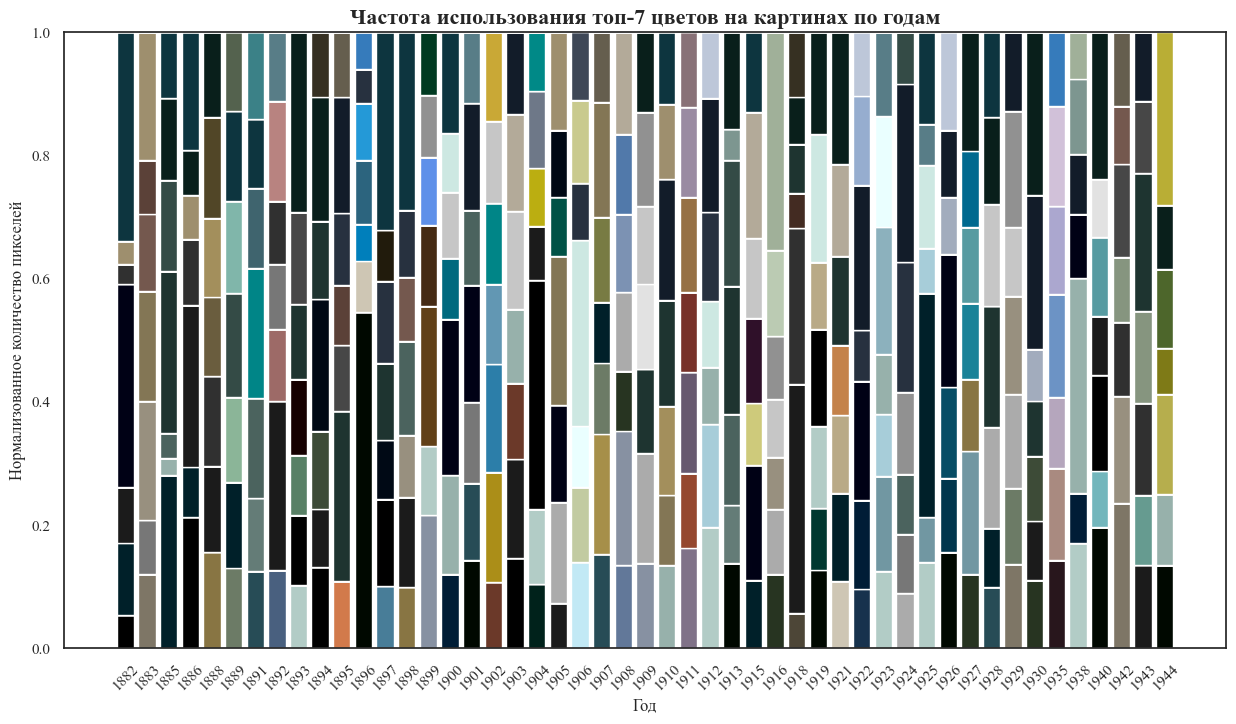

In [106]:
plot_color_distribution(colors_by_year, how='not_sorted', classifier='Counter')

Отсортировано по яркости:

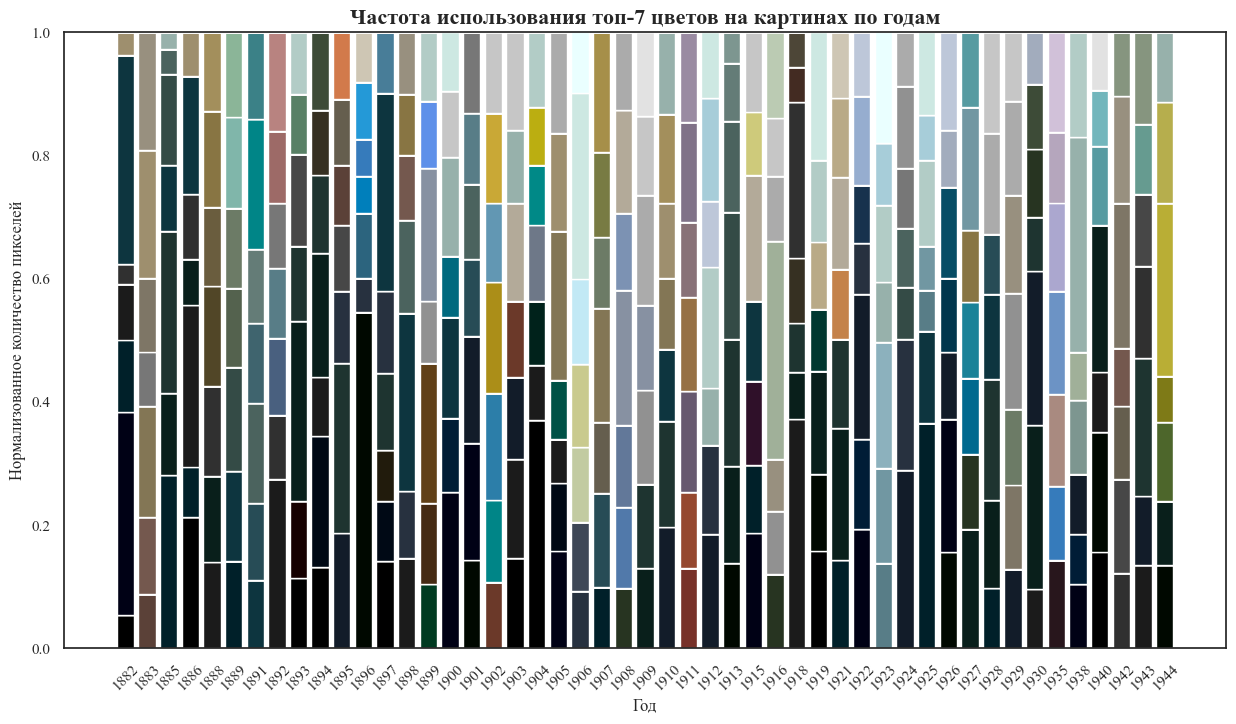

In [107]:
plot_color_distribution(colors_by_year, how='sorted', classifier='Counter')

#### GaussianMixture:

In [108]:
colors_by_year_gm = get_colors_by_year(folder_path, classifier='GM')

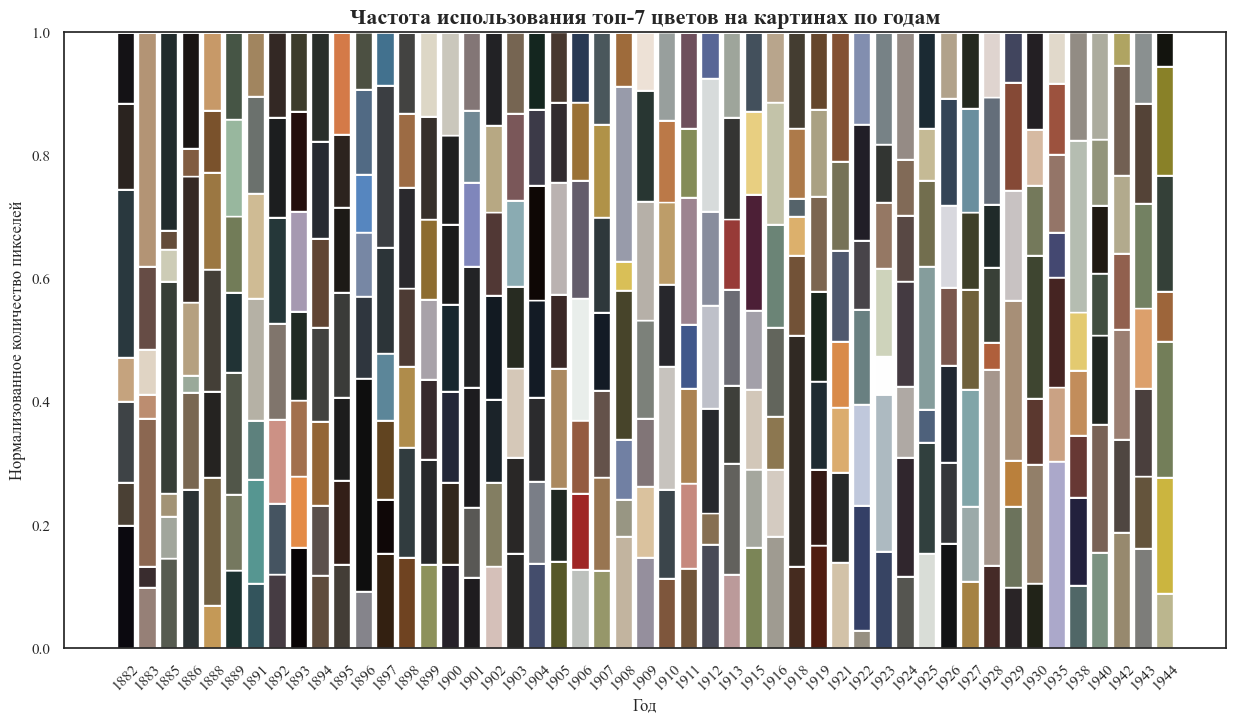

In [109]:
plot_color_distribution(colors_by_year_gm, how='not_sorted', classifier='GM')

Отсортировано по яркости:

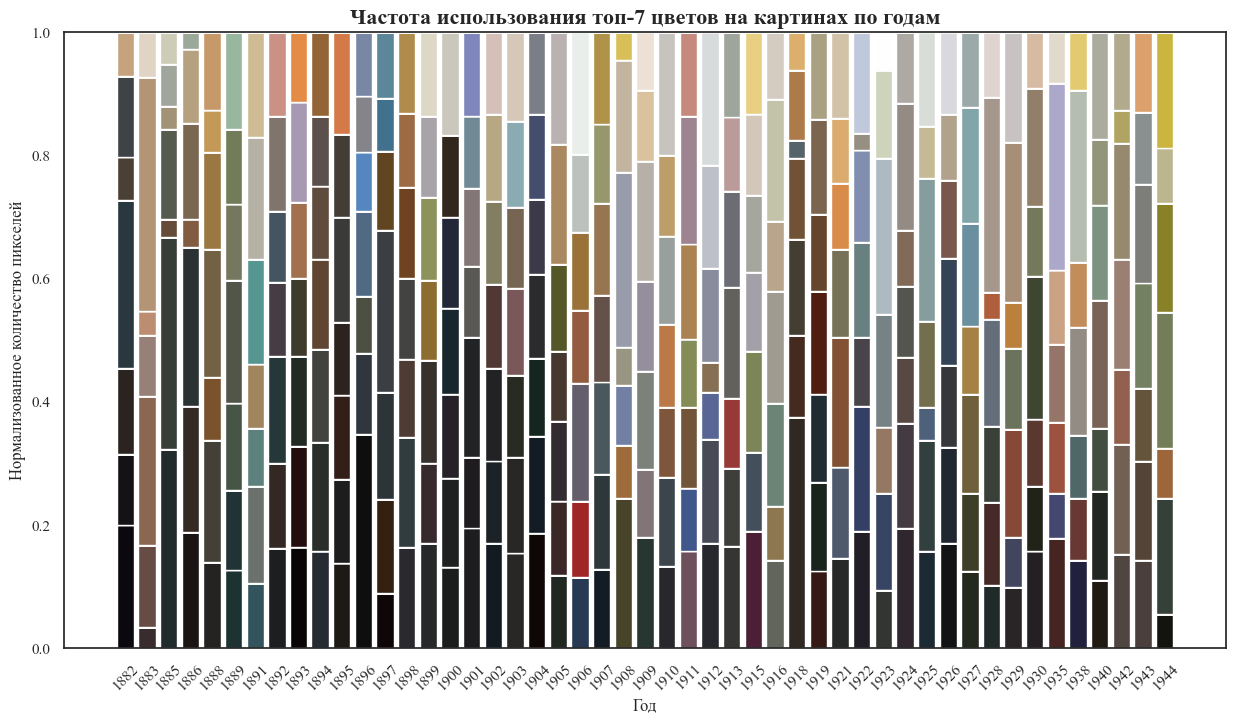

In [110]:
plot_color_distribution(colors_by_year_gm, how='sorted', classifier='GM')

In [111]:
# colors_by_year_gm

In [112]:
rows = []
for year, colors in colors_by_year_gm.items():
    color_list = list(colors.items())[:7]  # Оставляем только 7 цветов
    row = [year]
    for i, ((r, g, b), count) in enumerate(color_list):
        row.extend([r, g, b, count])  # Добавляем R, G, B и Count
    rows.append(row)
    
columns = ['year']
for i in range(1, 8):  # 7 цветов
    columns.extend([f'R{i}', f'G{i}', f'B{i}', f'Count{i}'])

# Создаем DataFrame
df = pd.DataFrame(rows, columns=columns)
df.head()

,year,R1,G1,B1,Count1,R2,G2,B2,Count2,R3,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1938,181,189,177,4582,146,140,132,2878,34,...,103,1676,103,56,52,1650,227,202,112,1548
1,1895,58,59,57,5652,212,122,72,5529,29,...,29,4527,67,61,54,4500,44,35,30,3950
2,1902,18,26,34,5729,34,34,37,5106,183,...,53,4566,27,35,41,4545,213,192,185,4505
3,1893,9,4,5,5059,35,14,13,5026,166,...,44,3942,162,112,77,3804,228,139,70,3518
4,1888,114,97,67,3417,68,63,55,3248,155,...,104,2073,122,82,44,1654,196,153,87,1131


In [113]:
# df_GM

In [114]:
df_GM = pd.merge(df_GM, df, on='year', how='inner')
df_GM.head()

,year,"(35, 36, 39)","(73, 64, 55)","(139, 125, 100)","(192, 184, 173)","(82, 98, 120)","(137, 77, 48)","(199, 160, 96)",R1,G1,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1882,9540,4024,844,230,13,36,271,41,56,...,21,3099,197,163,126,1913,74,64,52,1858
1,1883,242,786,2828,410,1,555,403,179,148,...,196,1206,188,141,112,631,57,44,46,541
2,1885,6573,3510,365,630,106,69,48,55,62,...,182,860,162,147,118,613,100,76,57,485
3,1886,5856,2217,830,376,37,330,120,43,50,...,128,1949,129,92,65,755,154,169,154,466
4,1888,2551,2783,870,21,10,945,1302,114,97,...,104,2073,122,82,44,1654,196,153,87,1131


In [115]:
df_counts['year'] = df_counts['year'].astype(int)

In [116]:
df_GM = pd.merge(df_GM, df_counts, on='year', how='inner')

In [117]:
df_GM.head()

,year,"(35, 36, 39)","(73, 64, 55)","(139, 125, 100)","(192, 184, 173)","(82, 98, 120)","(137, 77, 48)","(199, 160, 96)",R1,G1,...,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7,count
0,1882,9540,4024,844,230,13,36,271,41,56,...,3099,197,163,126,1913,74,64,52,1858,2
1,1883,242,786,2828,410,1,555,403,179,148,...,1206,188,141,112,631,57,44,46,541,1
2,1885,6573,3510,365,630,106,69,48,55,62,...,860,162,147,118,613,100,76,57,485,1
3,1886,5856,2217,830,376,37,330,120,43,50,...,1949,129,92,65,755,154,169,154,466,1
4,1888,2551,2783,870,21,10,945,1302,114,97,...,2073,122,82,44,1654,196,153,87,1131,1


In [118]:
df_GM.to_csv('data_GM.csv', index=False)

#### KMeans:

In [119]:
colors_by_year_km = get_colors_by_year(folder_path, classifier='KMeans')

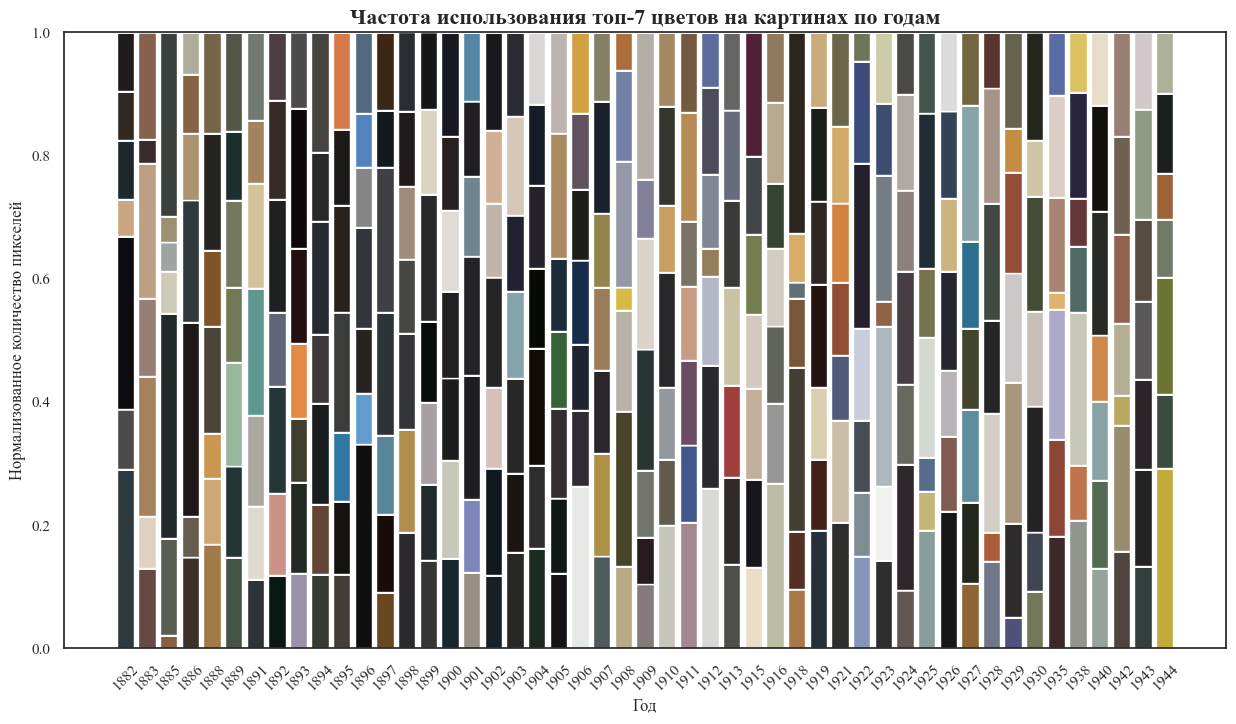

In [120]:
plot_color_distribution(colors_by_year_km, how='not_sorted', classifier='KMeans')

Отсортировано по яркости:

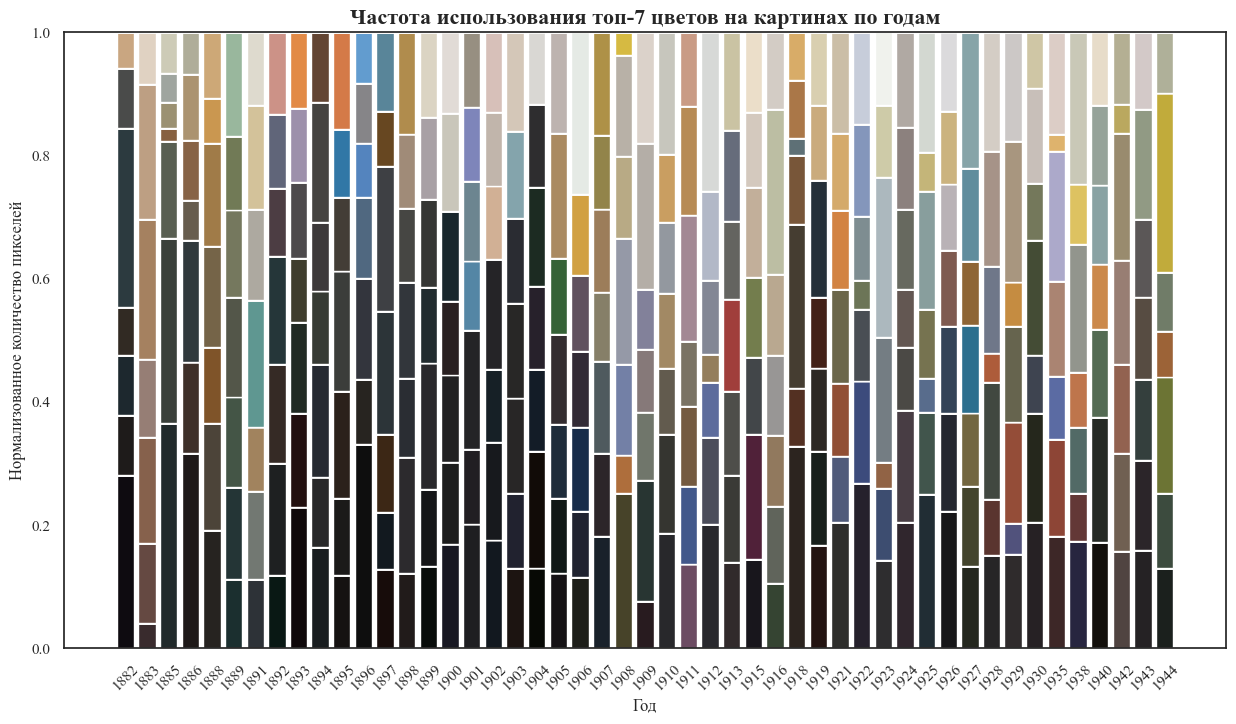

In [121]:
plot_color_distribution(colors_by_year_km, how='sorted', classifier='KMeans')

In [122]:
# colors_by_year_km

In [123]:
rows = []
for year, colors in colors_by_year_km.items():
    color_list = list(colors.items())[:7]  # Оставляем только 7 цветов
    row = [year]
    for i, ((r, g, b), count) in enumerate(color_list):
        row.extend([r, g, b, count])  # Добавляем R, G, B и Count
    rows.append(row)
    
columns = ['year']
for i in range(1, 8):  # 7 цветов
    columns.extend([f'R{i}', f'G{i}', f'B{i}', f'Count{i}'])

# Создаем DataFrame
df = pd.DataFrame(rows, columns=columns)
df.head()

,year,R1,G1,B1,Count1,R2,G2,B2,Count2,R3,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1938,201,200,183,4054,146,149,141,3406,39,...,97,1589,190,117,76,1460,99,56,54,1285
1,1895,59,61,58,7344,43,33,27,6505,212,...,54,4498,21,18,17,4462,49,119,166,4163
2,1902,37,36,39,7135,18,24,31,6956,23,...,171,4754,209,176,149,4731,22,32,38,4686
3,1893,15,8,10,7569,34,15,15,5083,33,...,70,4076,157,144,171,4014,63,61,45,3435
4,1888,38,35,32,3126,76,68,57,2851,160,...,41,2011,205,168,119,1766,202,151,80,1181


In [124]:
df_KMeans = pd.merge(df_KMeans, df, on='year', how='inner')
df_KMeans.head()

,year,"(36, 35, 39)","(76, 70, 60)","(197, 189, 178)","(135, 123, 95)","(100, 117, 145)","(153, 80, 50)","(198, 159, 84)",R1,G1,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1882,9503,3978,269,802,0,5,7,44,58,...,26,2584,49,42,35,2105,201,166,129,1593
1,1883,252,884,463,2527,0,189,68,165,129,...,117,2070,224,210,194,1390,57,43,45,662
2,1885,6388,3420,602,407,22,49,29,33,42,...,159,769,155,145,114,692,135,96,64,345
3,1886,5862,1731,254,948,10,126,30,30,25,...,70,1572,175,173,153,1112,103,93,78,1067
4,1888,2627,2598,22,990,1,502,1049,38,35,...,41,2011,205,168,119,1766,202,151,80,1181


In [125]:
df_counts['year'] = df_counts['year'].astype(int)
df_KMeans = pd.merge(df_KMeans, df_counts, on='year', how='inner')

In [126]:
df_KMeans.head()

,year,"(36, 35, 39)","(76, 70, 60)","(197, 189, 178)","(135, 123, 95)","(100, 117, 145)","(153, 80, 50)","(198, 159, 84)",R1,G1,...,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7,count
0,1882,9503,3978,269,802,0,5,7,44,58,...,2584,49,42,35,2105,201,166,129,1593,2
1,1883,252,884,463,2527,0,189,68,165,129,...,2070,224,210,194,1390,57,43,45,662,1
2,1885,6388,3420,602,407,22,49,29,33,42,...,769,155,145,114,692,135,96,64,345,1
3,1886,5862,1731,254,948,10,126,30,30,25,...,1572,175,173,153,1112,103,93,78,1067,1
4,1888,2627,2598,22,990,1,502,1049,38,35,...,2011,205,168,119,1766,202,151,80,1181,1


In [127]:
df_KMeans.to_csv('data_KMeans.csv', index=False)

#### BayesianGaussianMixture:

In [128]:
colors_by_year_bgm = get_colors_by_year(folder_path, classifier='GMM')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initializa

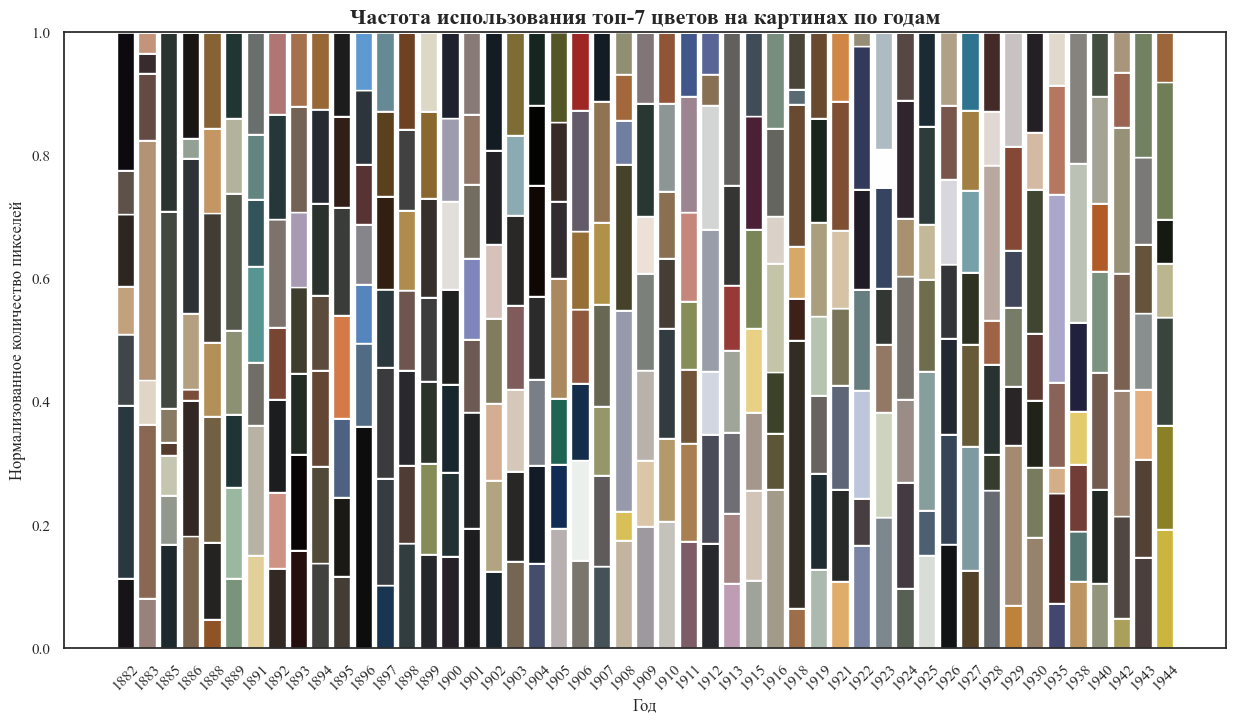

In [129]:
plot_color_distribution(colors_by_year_bgm, classifier='GMM', how='not_sorted')

Отсортировано по яркости:

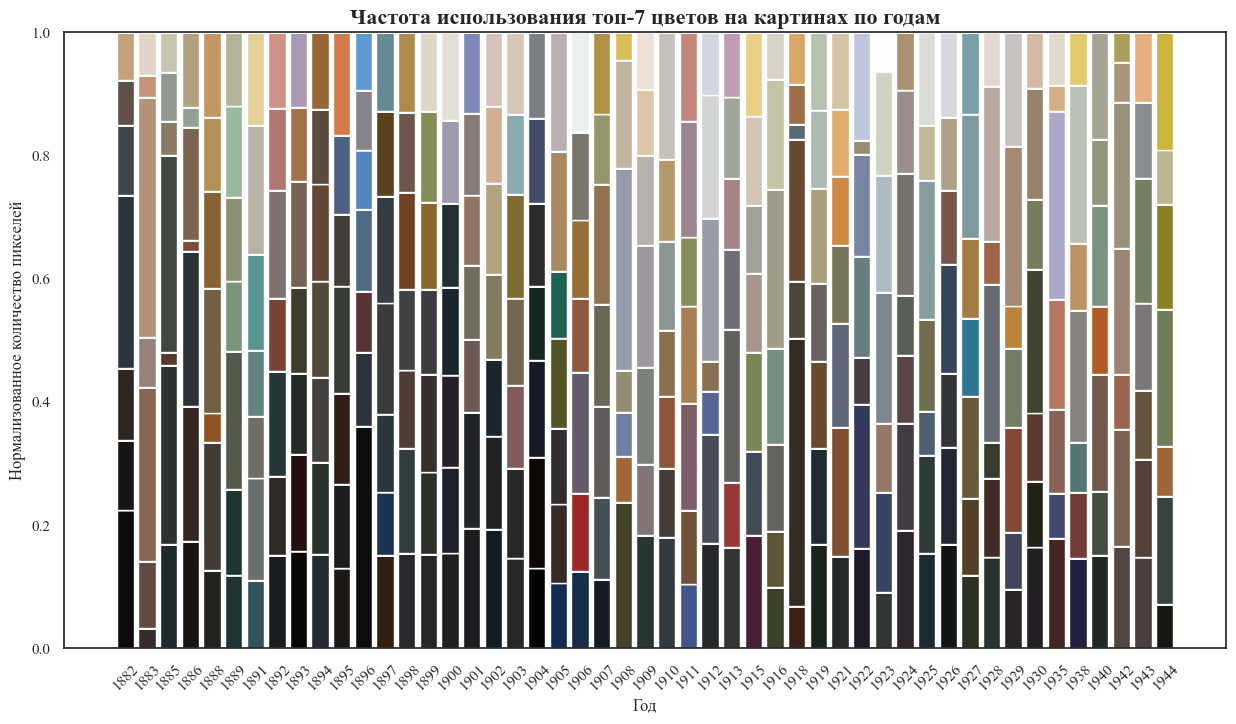

In [130]:
plot_color_distribution(colors_by_year_bgm, how='sorted', classifier='GMM')

In [131]:
rows = []
for year, colors in colors_by_year_bgm.items():
    color_list = list(colors.items())[:7]  # Оставляем только 7 цветов
    row = [year]
    for i, ((r, g, b), count) in enumerate(color_list):
        row.extend([r, g, b, count])  # Добавляем R, G, B и Count
    rows.append(row)
    
columns = ['year']
for i in range(1, 8):  # 7 цветов
    columns.extend([f'R{i}', f'G{i}', f'B{i}', f'Count{i}'])

# Создаем DataFrame
df = pd.DataFrame(rows, columns=columns)
df.head()

,year,R1,G1,B1,Count1,R2,G2,B2,Count2,R3,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1938,187,193,181,4209,134,131,127,3502,34,...,55,1773,227,202,107,1413,84,119,115,1327
1,1895,58,60,58,5745,212,121,72,5558,48,...,21,4262,77,97,131,4215,67,61,54,3840
2,1902,19,27,35,6699,34,34,37,5286,179,...,45,4358,211,174,147,4336,215,194,187,4202
3,1893,116,98,84,5873,36,15,14,5363,9,...,35,4438,168,154,178,4128,165,113,77,4076
4,1888,65,61,53,3415,113,96,66,3336,134,...,34,2058,178,144,87,1979,143,83,37,767


In [132]:
df_BGM = pd.merge(df_BGM, df, on='year', how='inner')
df_BGM.head()

,year,"(126, 124, 113)","(51, 50, 49)","(125, 78, 53)","(199, 164, 114)","(201, 195, 184)","(21, 22, 24)","(55, 73, 93)",R1,G1,...,B5,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7
0,1882,471,11074,229,1465,303,11192,1388,41,56,...,22,2946,195,161,125,2053,93,81,74,1882
1,1883,814,321,1403,1988,492,135,17,178,147,...,198,1148,195,148,122,576,56,43,46,521
2,1885,577,6982,126,103,561,2532,481,66,72,...,176,1061,137,122,99,912,84,59,43,350
3,1886,307,5684,612,469,154,4721,477,44,50,...,128,2013,146,161,147,532,121,77,57,299
4,1888,333,2897,1588,1141,20,1710,20,65,61,...,34,2058,178,144,87,1979,143,83,37,767


In [133]:
df_counts['year'] = df_counts['year'].astype(int)
df_BGM = pd.merge(df_BGM, df_counts, on='year', how='inner')

In [134]:
df_BGM.head()

,year,"(126, 124, 113)","(51, 50, 49)","(125, 78, 53)","(199, 164, 114)","(201, 195, 184)","(21, 22, 24)","(55, 73, 93)",R1,G1,...,Count5,R6,G6,B6,Count6,R7,G7,B7,Count7,count
0,1882,471,11074,229,1465,303,11192,1388,41,56,...,2946,195,161,125,2053,93,81,74,1882,2
1,1883,814,321,1403,1988,492,135,17,178,147,...,1148,195,148,122,576,56,43,46,521,1
2,1885,577,6982,126,103,561,2532,481,66,72,...,1061,137,122,99,912,84,59,43,350,1
3,1886,307,5684,612,469,154,4721,477,44,50,...,2013,146,161,147,532,121,77,57,299,1
4,1888,333,2897,1588,1141,20,1710,20,65,61,...,2058,178,144,87,1979,143,83,37,767,1


In [135]:
df_BGM.to_csv('data_BGM.csv', index=False)